In [1]:
from loading_augmenting_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot, gen_labels, gen_audio_array_noexcel

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, _, index_longest = gen_audio_array(audio_path,df)
audio_files_long, _, filenames_long, longest_file = gen_audio_array_noexcel(audio_path_long)
labels = df['label']
labels_long = gen_labels(filenames_long)

Adding labels


100%|█████████████████████████████████████| 413/413 [00:00<00:00, 170597.55it/s]


Finding longest file (Better Labels)


100%|█████████████████████████████████████████| 413/413 [00:08<00:00, 46.01it/s]


Loading files


100%|█████████████████████████████████████████| 413/413 [00:07<00:00, 57.58it/s]


Finding longest file (Worse Labels)


100%|███████████████████████████████████████| 1719/1719 [01:09<00:00, 24.86it/s]


Loading files


100%|███████████████████████████████████████| 1719/1719 [01:02<00:00, 27.39it/s]


In [4]:
augmented_audio = augment_audio(audio_files)
augmented_audio_long = augment_audio(audio_files_long)

Augmenting Non-noise


100%|████████████████████████████████████████| 413/413 [00:01<00:00, 405.01it/s]


Making noise


100%|█████████████████████████████████████████| 413/413 [00:09<00:00, 42.07it/s]


Augmenting Non-noise


100%|██████████████████████████████████████| 1719/1719 [00:15<00:00, 111.15it/s]


Making noise


100%|███████████████████████████████████████| 1719/1719 [01:47<00:00, 16.01it/s]


In [5]:
augmented_audio.shape

(5, 413, 127753)

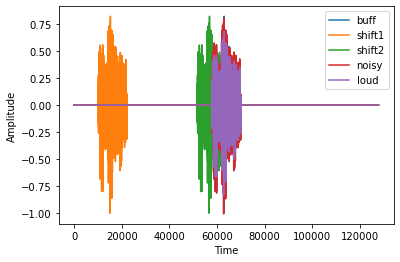

In [14]:
plot_sample(augmented_audio,100)

In [7]:
stfts = calc_stft(augmented_audio)
stfts_long = calc_stft(augmented_audio_long)
#mels = calc_melstft(augmented_audio)

Augmentation  0


100%|████████████████████████████████████████| 413/413 [00:03<00:00, 126.73it/s]


Augmentation  1


100%|████████████████████████████████████████| 413/413 [00:03<00:00, 120.16it/s]


Augmentation  2


100%|████████████████████████████████████████| 413/413 [00:03<00:00, 119.78it/s]


Augmentation  3


100%|████████████████████████████████████████| 413/413 [00:03<00:00, 120.36it/s]


Augmentation  4


100%|████████████████████████████████████████| 413/413 [00:03<00:00, 122.44it/s]


Augmentation  0


100%|███████████████████████████████████████| 1719/1719 [00:39<00:00, 43.59it/s]


Augmentation  1


100%|███████████████████████████████████████| 1719/1719 [00:39<00:00, 43.07it/s]


Augmentation  2


100%|███████████████████████████████████████| 1719/1719 [00:40<00:00, 42.21it/s]


Augmentation  3


100%|███████████████████████████████████████| 1719/1719 [00:40<00:00, 42.09it/s]


Augmentation  4


100%|███████████████████████████████████████| 1719/1719 [00:40<00:00, 42.24it/s]


In [8]:
stfts.shape

(5, 413, 1025, 250)

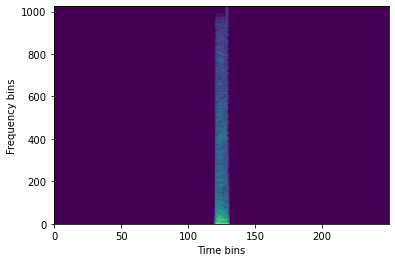

In [9]:
spec_plot(stfts[4,400,:,:])

In [10]:
#np.save('stfts_array',stfts)
#np.save('stfts_array_long',stfts)

In [11]:
#stfts = np.load('stfts_array.npy')
#stfts_long = np.load('stfts_array_long.npy')